In [2]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import umap.umap_ as umap
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/oskardale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oskardale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oskardale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

def evaluate_doc2vec(documents, vector_sizes=[100, 200, 300], windows=[5, 10, 15]):
    results = []
    train_docs, test_docs = train_test_split(documents, test_size=0.3, random_state=42)

    for vec_size in vector_sizes:
        for window in windows:
            model = Doc2Vec(
                vector_size=vec_size,
                window=window,
                min_count=2,
                workers=4,
                epochs=30
            )

            model.build_vocab(train_docs)
            model.train(train_docs, total_examples=model.corpus_count, epochs=30)

            # Alternative evaluation using document vector similarity
            similarities = []
            for doc in test_docs:
                inferred_vector = model.infer_vector(doc.words)
                similar_docs = model.dv.most_similar([inferred_vector], topn=1)
                similarities.append(similar_docs[0][1])  # Get the similarity score

            avg_similarity = np.mean(similarities)

            results.append({
                'vector_size': vec_size,
                'window': window,
                'score': avg_similarity
            })

    return pd.DataFrame(results)

In [54]:
from sklearn.metrics import silhouette_score
import umap.umap_ as umap

def evaluate_umap_params(doc_vectors, n_neighbors_range=[5, 15, 30, 50],
                        min_dist_range=[0.0, 0.1, 0.25, 0.5]):
    results = []

    for n_neighbors in n_neighbors_range:
        for min_dist in min_dist_range:
            # Fit UMAP
            umap_reducer = umap.UMAP(
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                n_components=2,
                random_state=42
            )
            embeddings = umap_reducer.fit_transform(doc_vectors)

            # Evaluate using silhouette score if we have labels
            if labels is not None:
                sil_score = silhouette_score(embeddings, labels)
                results.append({
                    'n_neighbors': n_neighbors,
                    'min_dist': min_dist,
                    'silhouette_score': sil_score
                })

    return pd.DataFrame(results)

In [60]:
def evaluate_hdbscan_params(embeddings,
                          min_cluster_sizes=[3, 5, 10, 15],
                          min_samples_range=[2, 3, 5, 10],
                          epsilon_range=[0.0, 0.1, 0.2, 0.5]):
    results = []

    for min_cluster_size in min_cluster_sizes:
        for min_samples in min_samples_range:
            for epsilon in epsilon_range:
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=min_cluster_size,
                    min_samples=min_samples,
                    cluster_selection_epsilon=epsilon,
                    metric='euclidean'
                )

                cluster_labels = clusterer.fit_predict(embeddings)

                # Calculate metrics
                n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
                noise_points = sum(1 for label in cluster_labels if label == -1)

                if n_clusters > 0:
                    sil_score = silhouette_score(embeddings, cluster_labels)
                else:
                    sil_score = 0

                results.append({
                    'min_cluster_size': min_cluster_size,
                    'min_samples': min_samples,
                    'epsilon': epsilon,
                    'n_clusters': n_clusters,
                    'noise_points': noise_points,
                    'silhouette_score': sil_score
                })

    return pd.DataFrame(results)

In [79]:
def check_clustering_stability(embeddings, clusterer, n_runs=10):
    cluster_results = []

    for i in range(n_runs):
        labels = clusterer.fit_predict(embeddings)
        cluster_results.append(labels)

    # Compare consistency across runs
    from sklearn.metrics import adjusted_rand_score
    stability_scores = []

    for i in range(len(cluster_results)):
        for j in range(i + 1, len(cluster_results)):
            ari = adjusted_rand_score(cluster_results[i], cluster_results[j])
            stability_scores.append(ari)

    return np.mean(stability_scores), np.std(stability_scores)

In [72]:
def plot_parameter_effects(results_df, metric='silhouette_score'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot effect of min_cluster_size
    sns.boxplot(data=results_df, x='min_cluster_size', y=metric, ax=axes[0])
    axes[0].set_title(f'Effect of min_cluster_size on {metric}')

    # Plot effect of min_samples
    sns.boxplot(data=results_df, x='min_samples', y=metric, ax=axes[1])
    axes[1].set_title(f'Effect of min_samples on {metric}')

    plt.tight_layout()
    plt.show()

In [14]:
# Load data
df0 = pd.read_csv('../0_data/statements.csv')
df1 = pd.read_csv('../0_data/eu_debate_transcripts_translated.csv')
df_chatgpt = df0[df0.provider == 'chatgpt']
df_deepseek = df0[df0.provider == 'deepseek']
documents_chatgpt = df_chatgpt.statement.values.tolist()
documents_deepseek = df_deepseek.statement.values.tolist()
documents_parliament = df1.translated_text.values.tolist()

# Preprocess text
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    tokens = word_tokenize(doc.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens
             if word.isalpha() and word.lower() not in stop_words and len(word) > 2]
    return tokens

clean_chatgpt = [preprocess_text(doc) for doc in documents_chatgpt]
clean_deepseek = [preprocess_text(doc) for doc in documents_deepseek]
clean_parliament = [preprocess_text(doc) for doc in documents_parliament]

all_documents = clean_parliament + clean_chatgpt + clean_deepseek
labels = ['Real'] * len(clean_parliament) + ['ChatGPT'] * len(clean_chatgpt) + ['DeepSeek'] * len(clean_deepseek)

In [47]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_documents)]
doc2vec_results = evaluate_doc2vec(documents)
best_doc2vec_params = doc2vec_results.loc[doc2vec_results['score'].idxmax()]

In [53]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_documents = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(all_documents)]

doc2vec_model = Doc2Vec(vector_size=int(best_doc2vec_params['vector_size']),
                       window=int(best_doc2vec_params['window']),
                       min_count=1)  # Consider words that appear at least once

doc2vec_model.build_vocab(tagged_documents)

doc2vec_model.train(tagged_documents,
                   total_examples=doc2vec_model.corpus_count,
                   epochs=20)

doc_vectors = np.array([doc2vec_model.infer_vector(doc) for doc in all_documents])

In [55]:
umap_results = evaluate_umap_params(doc_vectors)
best_umap_params = umap_results.loc[umap_results['silhouette_score'].idxmax()]

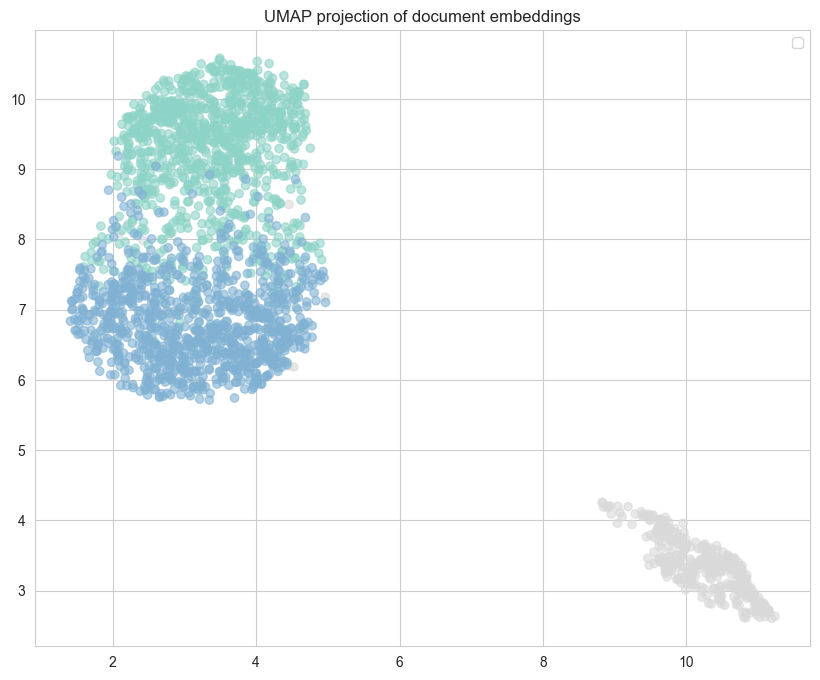

In [59]:
# Project to lower dimension using UMAP
umap_reducer = umap.UMAP(n_neighbors=int(best_umap_params['n_neighbors']),
                         min_dist=float(best_umap_params['min_dist']),
                         metric='cosine',
                         random_state=42)
embeddings = umap_reducer.fit_transform(doc_vectors)

# Visualize UMAP projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                     c=[plt.cm.Set3(i/3) for i in pd.Categorical(labels).codes], alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(labels)))
plt.title('UMAP projection of document embeddings')
plt.show()

In [61]:
hdbscan_results = evaluate_hdbscan_params(embeddings)
best_hdbscan_params = hdbscan_results.loc[hdbscan_results['silhouette_score'].idxmax()]

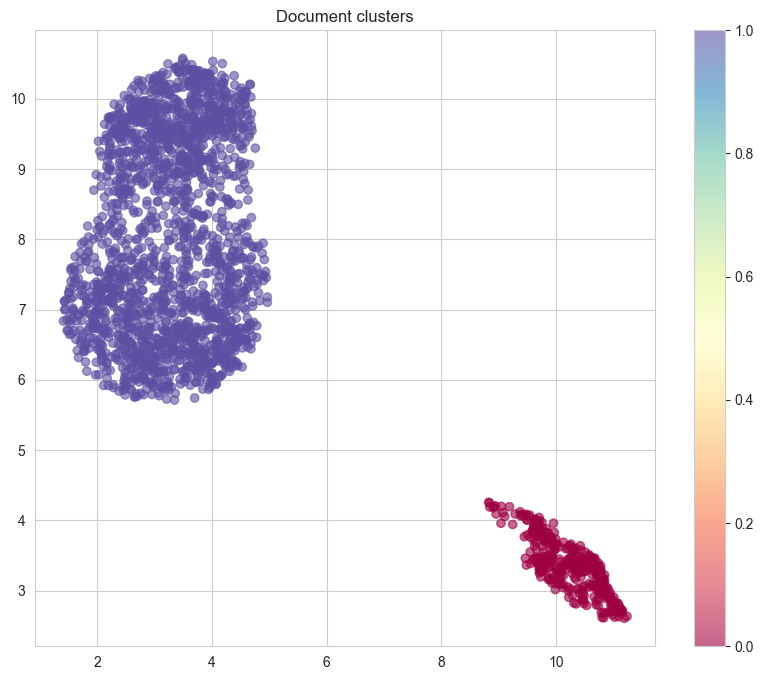

In [80]:
# Cluster the UMAP embeddings
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_hdbscan_params['min_cluster_size'].astype(int),
    min_samples=best_hdbscan_params['min_samples'].astype(int),
    cluster_selection_epsilon=float(best_hdbscan_params['epsilon']),
    metric='euclidean'
)

cluster_labels = clusterer.fit_predict(umap_embeddings)

# Visualize clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                     c=cluster_labels, cmap='Spectral', alpha=0.6)
plt.colorbar(scatter)
plt.title('Document clusters')
plt.show()

In [81]:
stability_mean, stability_std = check_clustering_stability(embeddings, clusterer, n_runs=10)
print(f"Clustering stability: {stability_mean:.3f} ± {stability_std:.3f}")

Clustering stability: 1.000 ± 0.000


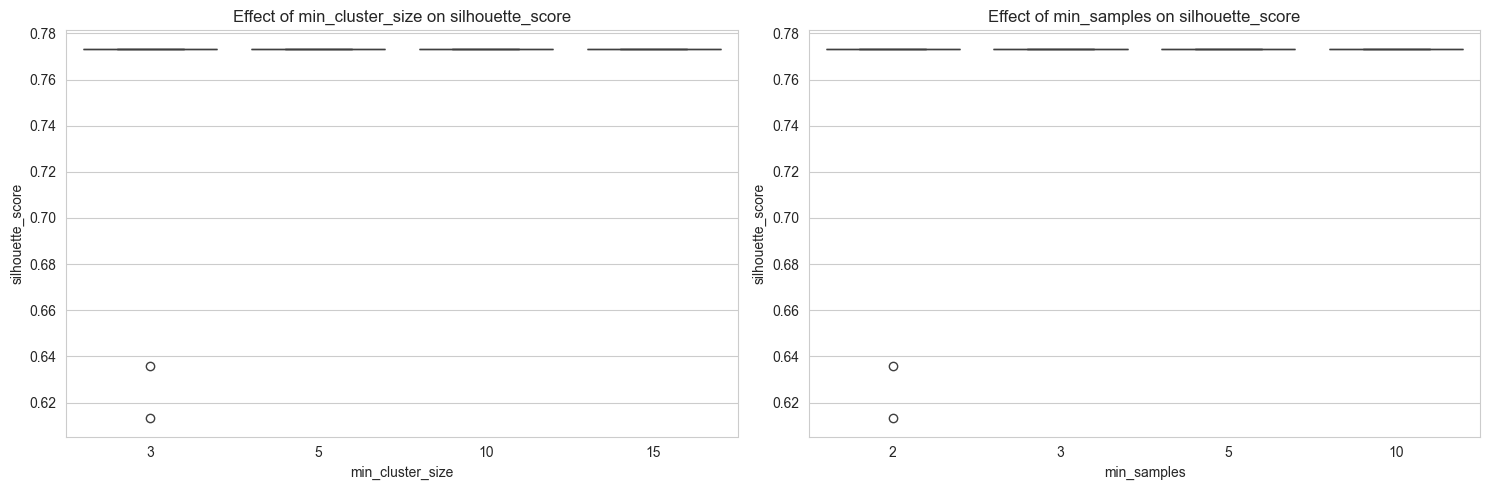

In [83]:
plot_parameter_effects(hdbscan_results)

In [38]:
# Calculate cluster centroids in original high-dimensional space
n_clusters = len(np.unique(cluster_labels[cluster_labels != -1]))

topic_vectors = []

for i in range(n_clusters):
    cluster_docs = doc_vectors[cluster_labels == i]
    centroid = np.mean(cluster_docs, axis=0)
    topic_vectors.append(centroid)

topic_vectors = np.array(topic_vectors)

In [39]:
def get_closest_words(topic_vector, word_vectors, n=10):
    similarities = cosine_similarity([topic_vector], word_vectors)[0]
    most_similar = np.argsort(similarities)[-n:][::-1]
    return most_similar

# Get all words from vocabulary
vocab = list(doc2vec_model.wv.key_to_index.keys())
word_vectors = np.array([doc2vec_model.wv[word] for word in vocab])

# Find closest words for each topic
print("Top words for each topic:")
for i, topic_vector in enumerate(topic_vectors):
    closest_word_indices = get_closest_words(topic_vector, word_vectors)
    closest_words = [vocab[idx] for idx in closest_word_indices]
    print(f"\nTopic {i + 1}:")
    print(", ".join(closest_words))

Top words for each topic:

Topic 1:
actually, sell, money, know, coming, well, afraid, chinese, tell, made

Topic 2:
match, economics, turbine, cobbler, writer, onmismisbaar, guatemala, battu, deported, applauded


In [40]:
# Create a DataFrame with cluster labels and sources
df_clusters = pd.DataFrame({
    'Cluster': cluster_labels,
    'Source': labels  # This contains the 'Real', 'ChatGPT', and 'DeepSeek' labels
})

# Create cross-tabulation
cluster_distribution = pd.crosstab(df_clusters['Cluster'], df_clusters['Source'])

# Add row totals
cluster_distribution['Total'] = cluster_distribution.sum(axis=1)

# Add column totals
cluster_distribution.loc['Total'] = cluster_distribution.sum()

# Rename the -1 cluster to 'Noise' for better readability
cluster_distribution.index = ['Noise' if x == -1 else f'Cluster {x}' for x in cluster_distribution.index]

# Display the table
print("\nDistribution of sources across clusters:")
print(cluster_distribution)


Distribution of sources across clusters:
Source         ChatGPT  DeepSeek  Real  Total
Cluster 0            0         0   366    366
Cluster 1         1000      1000     8   2008
Cluster Total     1000      1000   374   2374
